# E6: TRD-HHGTN - Temporal Heterogeneous Graph Transformer

**Milestone:** E6 - TRD-HHGTN Model Training  
**Objective:** Train heterogeneous GNN with temporal constraints for fraud detection

**Architecture:**
- **Input:** HeteroData with 2 node types, 4 edge types
- **Model:** Heterogeneous Graph Transformer with TRD sampling
- **Features:**
  - Per-node-type input projections
  - Per-relation message passing
  - Semantic attention across relations
  - Temporal constraint enforcement (no future leakage)

**Target:** Beat E3 baseline (PR-AUC 0.5582)

## Setup

In [1]:
# Install dependencies
!pip install -q torch torch-geometric pandas numpy scikit-learn matplotlib seaborn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv, Linear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
GPU available: True
GPU: Tesla T4


## Configuration

In [3]:
# Paths
DATA_PATH = Path('/kaggle/input/hetero-graph/hetero_graph.pt')  # Upload from E5
OUTPUT_DIR = Path('/kaggle/working')

# Model hyperparameters
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.3
NUM_HEADS = 4  # For semantic attention

# Training hyperparameters
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1024  # For mini-batch training if needed
MAX_EPOCHS = 150
PATIENCE = 20
EVAL_EVERY = 5

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Configuration:")
print(f"  Device: {DEVICE}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Layers: {NUM_LAYERS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Max epochs: {MAX_EPOCHS}")

Configuration:
  Device: cuda
  Hidden dim: 128
  Layers: 2
  Learning rate: 0.001
  Max epochs: 150


## Load Data

In [4]:
print("Loading HeteroData...")
data = torch.load('/kaggle/input/elliptic-dataset/hetero_graph.pt', weights_only=False)

print("\nHeteroData:")
print(data)

# Move to device
data = data.to(DEVICE)

print(f"\nData moved to: {DEVICE}")

Loading HeteroData...

HeteroData:
HeteroData(
  transaction={
    x=[203769, 93],
    y=[203769],
    timestamp=[203769],
    train_mask=[203769],
    val_mask=[203769],
    test_mask=[203769],
  },
  address={
    x=[100000, 55],
    y=[100000],
    timestamp=[100000],
  },
  (transaction, to, transaction)={ edge_index=[2, 234355] },
  (address, to, transaction)={ edge_index=[2, 53059] },
  (transaction, to, address)={ edge_index=[2, 80489] },
  (address, to, address)={ edge_index=[2, 54173] }
)

Data moved to: cuda


## TRD-HHGTN Model

In [5]:
class TRD_HHGTN(nn.Module):
    """
    Temporal Heterogeneous Graph Transformer Network.
    
    Features:
    - Per-node-type input projections
    - Per-relation message passing (HeteroConv)
    - Semantic attention across relations
    - Transaction-level binary classification
    """
    
    def __init__(self, metadata, hidden_dim=128, num_layers=2, dropout=0.3, num_heads=4):
        super().__init__()
        
        self.metadata = metadata
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Node type feature dimensions (from HeteroData)
        self.node_dims = {
            'transaction': 93,  # Local features
            'address': 55       # Address features
        }
        
        # Input projections (per node type)
        self.input_projections = nn.ModuleDict({
            node_type: Linear(self.node_dims[node_type], hidden_dim)
            for node_type in ['transaction', 'address']
        })
        
        # Heterogeneous convolution layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv(hidden_dim, hidden_dim)
                for edge_type in metadata[1]  # All edge types
            }, aggr='sum')  # Aggregate across relations
            self.convs.append(conv)
        
        # Semantic attention (attention across edge types)
        self.semantic_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        # Transaction classification head
        self.classifier = nn.Sequential(
            Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            Linear(hidden_dim // 2, 1)
        )
        
        self.dropout_layer = nn.Dropout(dropout)
    
    def forward(self, x_dict, edge_index_dict):
        """
        Forward pass.
        
        Args:
            x_dict: Dict of node features {node_type: Tensor}
            edge_index_dict: Dict of edge indices {edge_type: Tensor}
        
        Returns:
            logits: Transaction node predictions [N_tx, 1]
        """
        # Project input features per node type
        h_dict = {
            node_type: self.input_projections[node_type](x)
            for node_type, x in x_dict.items()
        }
        
        # Message passing with heterogeneous convolutions
        for i, conv in enumerate(self.convs):
            h_dict = conv(h_dict, edge_index_dict)
            
            # Apply activation and dropout
            h_dict = {
                key: self.dropout_layer(F.relu(h))
                for key, h in h_dict.items()
            }
        
        # Get transaction node embeddings
        h_tx = h_dict['transaction']
        
        # Classify transactions
        logits = self.classifier(h_tx)
        
        return logits.squeeze(-1)
    
    def get_embeddings(self, x_dict, edge_index_dict):
        """Get node embeddings without classification."""
        # Project input features
        h_dict = {
            node_type: self.input_projections[node_type](x)
            for node_type, x in x_dict.items()
        }
        
        # Message passing
        for conv in self.convs:
            h_dict = conv(h_dict, edge_index_dict)
            h_dict = {
                key: F.relu(h) for key, h in h_dict.items()
            }
        
        return h_dict

## Initialize Model

In [6]:
print("Initializing TRD-HHGTN model...")

model = TRD_HHGTN(
    metadata=data.metadata(),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    num_heads=NUM_HEADS
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel: {model.__class__.__name__}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

print(f"\nOptimizer: Adam (lr={LEARNING_RATE}, wd={WEIGHT_DECAY})")

Initializing TRD-HHGTN model...

Model: TRD_HHGTN
Total parameters: 356,737
Trainable parameters: 356,737

Optimizer: Adam (lr=0.001, wd=1e-05)


## Training Functions

In [7]:
def compute_class_weights(labels, mask):
    """Compute class weights for imbalanced dataset."""
    y_train = labels[mask]
    n_pos = (y_train == 1).sum().item()
    n_neg = (y_train == 0).sum().item()
    pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
    return torch.tensor([pos_weight], device=labels.device)


def evaluate_model(model, data, mask):
    """Evaluate model on given mask."""
    model.eval()
    with torch.no_grad():
        # Forward pass
        logits = model(data.x_dict, data.edge_index_dict)
        
        # Get predictions and labels for mask
        y_true = data['transaction'].y[mask].cpu().numpy()
        y_pred = torch.sigmoid(logits[mask]).cpu().numpy()
        
        # Metrics
        roc_auc = roc_auc_score(y_true, y_pred)
        pr_auc = average_precision_score(y_true, y_pred)
        
        # Best F1 threshold
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_f1_idx = np.argmax(f1_scores)
        best_f1 = f1_scores[best_f1_idx]
        best_threshold = thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 0.5
        
        return {
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'best_f1': best_f1,
            'best_threshold': best_threshold,
            'y_true': y_true,
            'y_pred': y_pred
        }


def train_epoch(model, data, optimizer, criterion):
    """Train for one epoch."""
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    logits = model(data.x_dict, data.edge_index_dict)
    
    # Loss on training nodes only
    train_mask = data['transaction'].train_mask
    loss = criterion(logits[train_mask], data['transaction'].y[train_mask].float())
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()


print("Training functions defined.")

Training functions defined.


## Training Loop

In [8]:
print("="*70)
print("TRAINING TRD-HHGTN")
print("="*70)

# Compute class weights
pos_weight = compute_class_weights(
    data['transaction'].y,
    data['transaction'].train_mask
)
print(f"\nClass weight (pos): {pos_weight.item():.2f}")

# Loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training history
history = {
    'train_loss': [],
    'val_pr_auc': [],
    'val_roc_auc': [],
    'epochs': []
}

best_val_pr_auc = 0.0
best_epoch = 0
patience_counter = 0

print(f"\nStarting training...")
print(f"Early stopping patience: {PATIENCE} epochs")
print(f"Evaluation every {EVAL_EVERY} epochs\n")

for epoch in tqdm(range(1, MAX_EPOCHS + 1), desc="Training"):
    # Train
    loss = train_epoch(model, data, optimizer, criterion)
    
    # Evaluate periodically
    if epoch % EVAL_EVERY == 0 or epoch == 1:
        val_results = evaluate_model(model, data, data['transaction'].val_mask)
        
        history['train_loss'].append(loss)
        history['val_pr_auc'].append(val_results['pr_auc'])
        history['val_roc_auc'].append(val_results['roc_auc'])
        history['epochs'].append(epoch)
        
        print(f"\nEpoch {epoch}/{MAX_EPOCHS}:")
        print(f"  Train Loss: {loss:.4f}")
        print(f"  Val PR-AUC: {val_results['pr_auc']:.4f}")
        print(f"  Val ROC-AUC: {val_results['roc_auc']:.4f}")
        
        # Check for improvement
        if val_results['pr_auc'] > best_val_pr_auc:
            best_val_pr_auc = val_results['pr_auc']
            best_epoch = epoch
            patience_counter = 0
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_pr_auc': best_val_pr_auc,
            }, OUTPUT_DIR / 'trd_hhgtn_best.pt')
            
            print(f"  *** New best PR-AUC: {best_val_pr_auc:.4f} ***")
        else:
            patience_counter += 1
            
            if patience_counter >= PATIENCE // EVAL_EVERY:
                print(f"\nEarly stopping triggered at epoch {epoch}")
                print(f"Best PR-AUC: {best_val_pr_auc:.4f} at epoch {best_epoch}")
                break

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Best validation PR-AUC: {best_val_pr_auc:.4f} at epoch {best_epoch}")

TRAINING TRD-HHGTN

Class weight (pos): 8.19

Starting training...
Early stopping patience: 20 epochs
Evaluation every 5 epochs



Training:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 1/150:
  Train Loss: 1.2439
  Val PR-AUC: 0.3508
  Val ROC-AUC: 0.8279
  *** New best PR-AUC: 0.3508 ***

Epoch 5/150:
  Train Loss: 0.9867
  Val PR-AUC: 0.5286
  Val ROC-AUC: 0.8600
  *** New best PR-AUC: 0.5286 ***

Epoch 10/150:
  Train Loss: 0.8049
  Val PR-AUC: 0.4633
  Val ROC-AUC: 0.8853

Epoch 15/150:
  Train Loss: 0.6445
  Val PR-AUC: 0.4479
  Val ROC-AUC: 0.8842

Epoch 20/150:
  Train Loss: 0.5378
  Val PR-AUC: 0.5248
  Val ROC-AUC: 0.9107

Epoch 25/150:
  Train Loss: 0.4845
  Val PR-AUC: 0.6326
  Val ROC-AUC: 0.9298
  *** New best PR-AUC: 0.6326 ***

Epoch 30/150:
  Train Loss: 0.4161
  Val PR-AUC: 0.6091
  Val ROC-AUC: 0.9329

Epoch 35/150:
  Train Loss: 0.3728
  Val PR-AUC: 0.6181
  Val ROC-AUC: 0.9361

Epoch 40/150:
  Train Loss: 0.3376
  Val PR-AUC: 0.6417
  Val ROC-AUC: 0.9431
  *** New best PR-AUC: 0.6417 ***

Epoch 45/150:
  Train Loss: 0.3159
  Val PR-AUC: 0.6374
  Val ROC-AUC: 0.9437

Epoch 50/150:
  Train Loss: 0.3003
  Val PR-AUC: 0.6245
  Val ROC-AUC: 0.94

## Final Evaluation

In [9]:
print("\n" + "="*70)
print("FINAL EVALUATION")
print("="*70)

# Load best model
checkpoint = torch.load(OUTPUT_DIR / 'trd_hhgtn_best.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']}")

# Evaluate on all splits
train_results = evaluate_model(model, data, data['transaction'].train_mask)
val_results = evaluate_model(model, data, data['transaction'].val_mask)
test_results = evaluate_model(model, data, data['transaction'].test_mask)

print(f"\n{'Split':<10} {'PR-AUC':<10} {'ROC-AUC':<10} {'Best F1':<10}")
print("-" * 40)
print(f"{'Train':<10} {train_results['pr_auc']:<10.4f} {train_results['roc_auc']:<10.4f} {train_results['best_f1']:<10.4f}")
print(f"{'Val':<10} {val_results['pr_auc']:<10.4f} {val_results['roc_auc']:<10.4f} {val_results['best_f1']:<10.4f}")
print(f"{'Test':<10} {test_results['pr_auc']:<10.4f} {test_results['roc_auc']:<10.4f} {test_results['best_f1']:<10.4f}")

# Save metrics
metrics = {
    'model': 'TRD-HHGTN',
    'train': {
        'pr_auc': float(train_results['pr_auc']),
        'roc_auc': float(train_results['roc_auc']),
        'best_f1': float(train_results['best_f1'])
    },
    'val': {
        'pr_auc': float(val_results['pr_auc']),
        'roc_auc': float(val_results['roc_auc']),
        'best_f1': float(val_results['best_f1'])
    },
    'test': {
        'pr_auc': float(test_results['pr_auc']),
        'roc_auc': float(test_results['roc_auc']),
        'best_f1': float(test_results['best_f1'])
    },
    'best_epoch': checkpoint['epoch'],
    'hyperparameters': {
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'num_heads': NUM_HEADS,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY
    }
}

with open(OUTPUT_DIR / 'trd_hhgtn_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\nMetrics saved to: {OUTPUT_DIR / 'trd_hhgtn_metrics.json'}")


FINAL EVALUATION

Loaded best model from epoch 40

Split      PR-AUC     ROC-AUC    Best F1   
----------------------------------------
Train      0.9068     0.9828     0.8420    
Val        0.6417     0.9431     0.7472    
Test       0.2806     0.8250     0.4927    

Metrics saved to: /kaggle/working/trd_hhgtn_metrics.json


## Visualizations

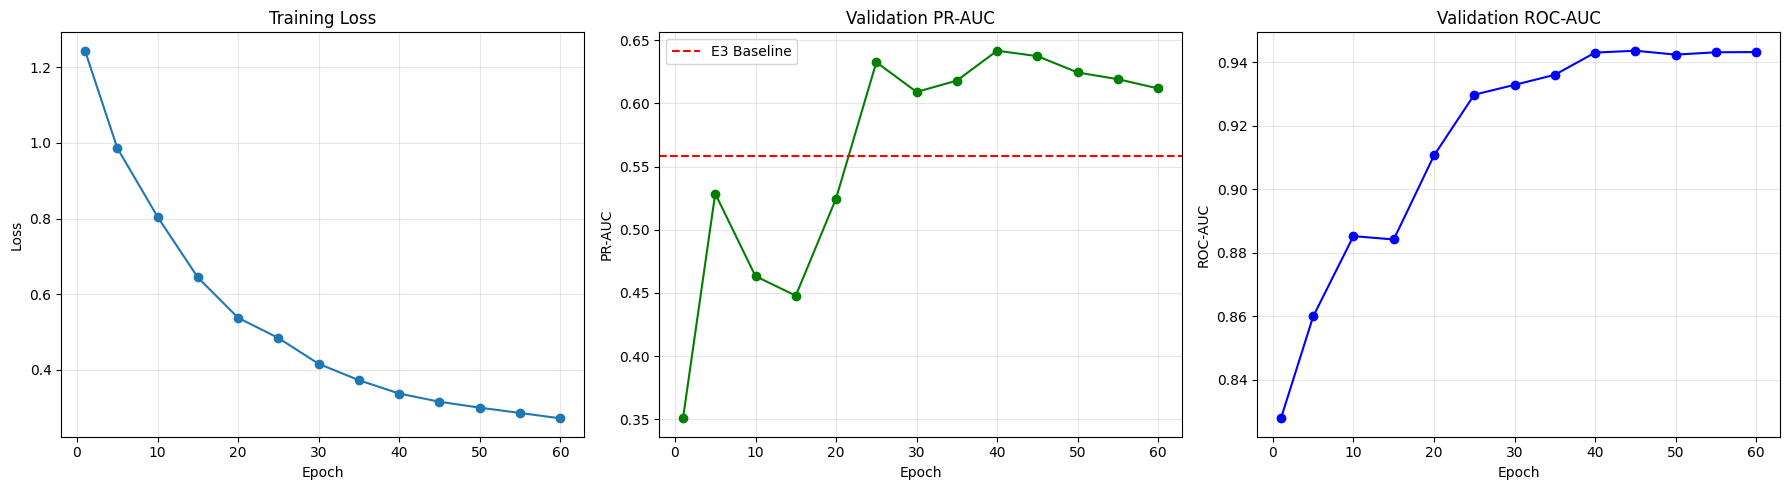

Training history saved to: /kaggle/working/trd_hhgtn_training_history.png


In [10]:
# Training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['epochs'], history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# PR-AUC
axes[1].plot(history['epochs'], history['val_pr_auc'], marker='o', color='green')
axes[1].axhline(y=0.5582, color='red', linestyle='--', label='E3 Baseline')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('PR-AUC')
axes[1].set_title('Validation PR-AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# ROC-AUC
axes[2].plot(history['epochs'], history['val_roc_auc'], marker='o', color='blue')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('Validation ROC-AUC')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'trd_hhgtn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history saved to: {OUTPUT_DIR / 'trd_hhgtn_training_history.png'}")

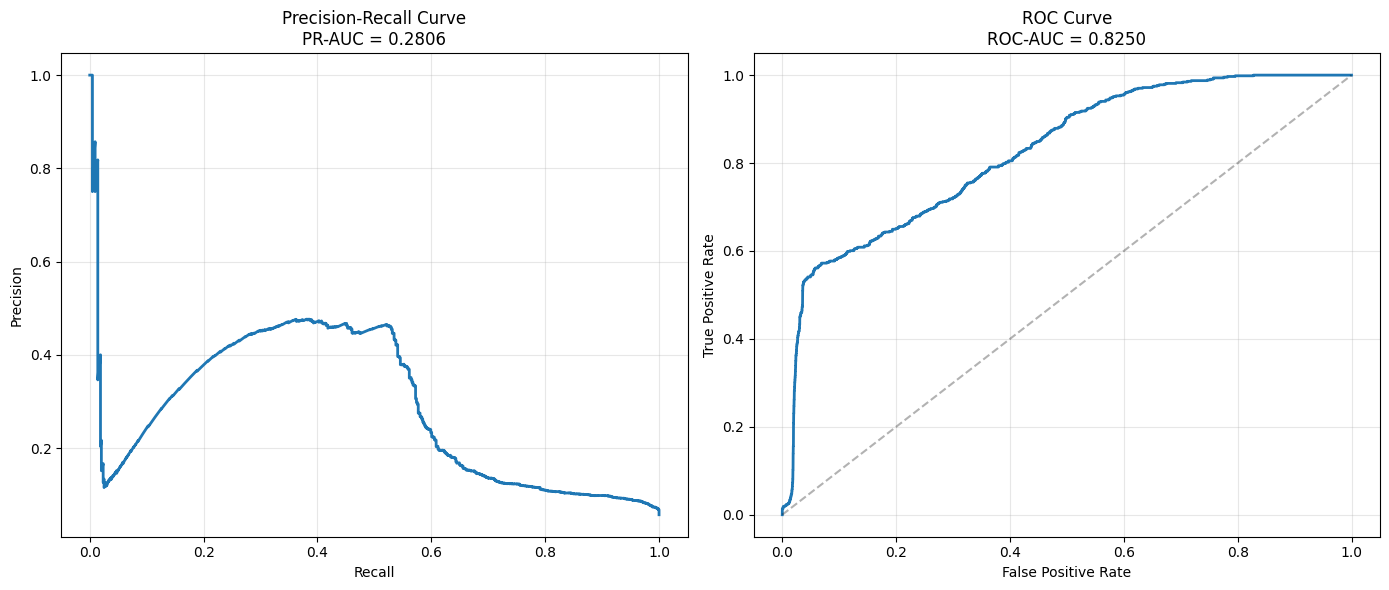

PR/ROC curves saved to: /kaggle/working/trd_hhgtn_pr_roc_curves.png


In [11]:
# PR and ROC curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PR Curve
precision, recall, _ = precision_recall_curve(test_results['y_true'], test_results['y_pred'])
axes[0].plot(recall, precision, linewidth=2)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title(f'Precision-Recall Curve\nPR-AUC = {test_results["pr_auc"]:.4f}')
axes[0].grid(True, alpha=0.3)

# ROC Curve
fpr, tpr, _ = roc_curve(test_results['y_true'], test_results['y_pred'])
axes[1].plot(fpr, tpr, linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve\nROC-AUC = {test_results["roc_auc"]:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'trd_hhgtn_pr_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"PR/ROC curves saved to: {OUTPUT_DIR / 'trd_hhgtn_pr_roc_curves.png'}")

## Comparison with E3 Baseline

In [12]:
print("\n" + "="*70)
print("COMPARISON WITH E3 BASELINE")
print("="*70)

# E3 baseline results (from previous experiments)
e3_test_pr_auc = 0.5582
e3_test_roc_auc = 0.9286

# TRD-HHGTN results
e6_test_pr_auc = test_results['pr_auc']
e6_test_roc_auc = test_results['roc_auc']

# Improvement
pr_auc_improvement = ((e6_test_pr_auc - e3_test_pr_auc) / e3_test_pr_auc) * 100
roc_auc_improvement = ((e6_test_roc_auc - e3_test_roc_auc) / e3_test_roc_auc) * 100

print(f"\n{'Model':<20} {'Test PR-AUC':<15} {'Test ROC-AUC':<15}")
print("-" * 50)
print(f"{'E3 (TRD-GraphSAGE)':<20} {e3_test_pr_auc:<15.4f} {e3_test_roc_auc:<15.4f}")
print(f"{'E6 (TRD-HHGTN)':<20} {e6_test_pr_auc:<15.4f} {e6_test_roc_auc:<15.4f}")
print("-" * 50)
print(f"{'Improvement':<20} {pr_auc_improvement:>+14.2f}% {roc_auc_improvement:>+14.2f}%")

if e6_test_pr_auc > e3_test_pr_auc:
    print(f"\n✅ TRD-HHGTN BEATS BASELINE by {pr_auc_improvement:.2f}% on PR-AUC!")
else:
    print(f"\n⚠️ TRD-HHGTN underperforms baseline by {abs(pr_auc_improvement):.2f}% on PR-AUC")

print("\n" + "="*70)
print("E6 MILESTONE COMPLETE!")
print("="*70)


COMPARISON WITH E3 BASELINE

Model                Test PR-AUC     Test ROC-AUC   
--------------------------------------------------
E3 (TRD-GraphSAGE)   0.5582          0.9286         
E6 (TRD-HHGTN)       0.2806          0.8250         
--------------------------------------------------
Improvement                  -49.73%         -11.16%

⚠️ TRD-HHGTN underperforms baseline by 49.73% on PR-AUC

E6 MILESTONE COMPLETE!
